In [1]:
import pandas as pd
import numpy as np
import time
import os, psutil
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='plotly_mimetype'

def printmem():
    process = psutil.Process(os.getpid())
    print("   memory:",round(process.memory_info().rss/(10**9),3),'Gbytes')  # in bytes 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tabulate import tabulate

In [2]:
def calc_performance_multi(y_vals_true, y_vals_pred,labels):
#
# Get the numbers for the confusion matrix
# To get output: cf_matrix[true_label,pred_label]
    cf_matrix = confusion_matrix(y_vals_true, y_vals_pred, labels=labels)
#
# This is a graphic
    cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=labels)
#
# Make the header row
    header = [""]
    for column_name in labels:
        header.append('Pred:' + str(column_name))
    table = [header]
#
# Now make the rows with the matrix
    for row_name in labels:
        row = ['True:'+str(row_name)]
        for column_name in labels:
            row_index = labels.index(row_name)
            column_index = labels.index(column_name)
            row.append(cf_matrix[row_index,column_index])
        table.append(row)
    # table = [
    #     [ "", "Predicted Class 1", "Precicted Class 0"],
    #     [ "True Class 1", TP, FN ],
    #     [ "True Class 0", FP, TN ]
    # ]
    print_table_type='fancy_grid'
    print_table = tabulate(table, headers='firstrow', tablefmt=print_table_type)
#    print(print_table)
#
# Get the recall, precision, ands F1 for each individual label
# - return both the "string report" (which you can print)
# - and the "dictionary report" (which you can use for averages and so on)
    report = classification_report(y_vals_true,y_vals_pred)
    report_dict = classification_report(y_vals_true,y_vals_pred,output_dict=True)
#
    results = {"confusionMatrix":cf_matrix,
                    'confusion_matrix_display':cf_disp,
                    'confusion_matrix_print_table':print_table,      
                    "report":report,"report_dict":report_dict}
    return results


def run_fitter_multi(estimator,X_train,y_train,X_test,y_test,labels):
#
# Now fit to our training set
    estimator.fit(X_train,y_train)
#
# Now predict the classes and get the score for our traing set
    y_train_pred = estimator.predict(X_train)
    y_train_score = estimator.predict_proba(X_train)   # NOTE: some estimators have a predict_prob method instead od descision_function
#
# Now predict the classes and get the score for our test set
    y_test_pred = estimator.predict(X_test)
    y_test_score = estimator.predict_proba(X_test)

#
# Now get the performaance
    results_test = calc_performance_multi(y_test,y_test_pred,labels)
    results_train = calc_performance_multi(y_train,y_train_pred,labels)
#
    return results_train,results_test

## Random Forest Classifier

In [3]:
dfTrain = pd.read_csv('train_expand_S_P.zip')
printmem()

   memory: 8.904 Gbytes


### Severity Classfication

Classification of patients severity class based on age, gender, symptoms and antecedent

In [4]:
dicMW = {'M': 0, 'F':1}

In [5]:
dfTrain['SEX'] = dfTrain['SEX'].map(dicMW)

In [6]:
cols_to_exclude = ['DIFFERENTIAL_DIAGNOSIS', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
df = dfTrain.loc[:, [col for col in dfTrain.columns if col not in cols_to_exclude]]
df.head()

,AGE,SEX,E_0,E_1,E_10,E_100,E_101,E_102,E_103,E_104,...,E_98,E_99,E_132,E_134,E_136,E_56,E_58,E_59,severity,pathoClass
0,18,0,0,0,0,0,0,0,0,0,...,0,0,-1,-1,-1,4,3,3,5,0
1,21,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,7,7,2,3,1
2,19,1,0,0,0,0,0,0,0,0,...,0,0,4,0,0,5,2,6,3,2
3,34,1,0,0,0,0,0,0,0,0,...,0,0,-1,-1,-1,7,5,4,5,0
4,36,0,0,0,0,0,0,0,0,0,...,0,0,-1,-1,-1,5,4,2,5,0


In [7]:
#df_sample = df.head(10000)
X = df.iloc[:, 0:-2].to_numpy()
y = df['severity'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
labels = [1,2,3,4,5]
num_classes = len(labels)

In [10]:
printmem()

   memory: 20.3 Gbytes


module4_2_random_forest

In [25]:
estimator = RandomForestClassifier(n_estimators=50, max_depth=7,random_state=42)

In [28]:
results_train, results_test = run_fitter_multi(estimator,X_train,y_train,X_test,y_test,labels)

In [29]:
printmem()

   memory: 20.214 Gbytes


## K-Fold Validation

In [32]:
kfolds = 5
skf = StratifiedKFold(n_splits=kfolds)

In [34]:
t0 = time.time()
#estimator = RandomForestClassifier(n_estimators=50, max_depth=7,random_state=42)

avg_precision_train = 0.0
avg_recall_train = 0.0
avg_f1_train = 0.0
avg_precision_test = 0.0
avg_recall_test = 0.0
avg_f1_test = 0.0
numSplits = 0.0
#
# Now loop

for train_index, test_index in skf.split(X, y):
    #print("Training")
    numSplits += 1
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]  
#
# Now fit to our training set
    results_train,results_test = run_fitter_multi(estimator,X_train,y_train,X_test,y_test,labels)

    avg_precision_train += results_train['report_dict']['weighted avg']['precision']
    avg_recall_train += results_train['report_dict']['weighted avg']['recall']
    avg_f1_train += results_train['report_dict']['weighted avg']['f1-score']
#
    avg_precision_test += results_test['report_dict']['weighted avg']['precision']
    avg_recall_test += results_test['report_dict']['weighted avg']['recall']
    avg_f1_test += results_test['report_dict']['weighted avg']['f1-score']
#
avg_precision_train /= numSplits
avg_recall_train /= numSplits
avg_f1_train /= numSplits
avg_precision_test /= numSplits
avg_recall_test /= numSplits
avg_f1_test /= numSplits
# 
# Now print
print("Precision train/test ",round(avg_precision_train,3),round(avg_precision_test,3))
print("Recall train/test    ",round(avg_recall_train,3),round(avg_recall_test,3))
print("F1 Score train/test       ",round(avg_f1_train,3),round(avg_f1_test,3))
print("All done! Time:", time.time()-t0)
printmem()

Precision train/test  0.924 0.921
Recall train/test     0.917 0.914
F1 Score train/test        0.917 0.914
All done! Time: 1.7886037826538086
   memory: 20.257 Gbytes


In [9]:
estimator.fit(X,y)
printmem()

   memory: 13.114 Gbytes


In [10]:
filename = 'forest50k.sav'
pickle.dump(estimator, open(filename, 'wb'))

In [10]:
estimator = pickle.load(open('forest10k.sav', 'rb'))

0.88976


In [19]:
df_check = dfTrain[50000:].sample(n=50000, random_state=42)
printmem()

   memory: 9.629 Gbytes


In [20]:
X_test = df_check.iloc[:, 6:-1].to_numpy()
y_test = df_check['severity'].values

In [21]:
y_train_pred = estimator.predict(X)
#
# Now predict the classes for our test set
y_test_pred = estimator.predict(X_test)
#
# Get resulst for train
results_train = calc_performance_multi(y,y_train_pred,labels)
#
# Get resulst for test
results_test = calc_performance_multi(y_test,y_test_pred,labels)

In [18]:
results_train['confusion_matrix_data']

array([[ 2871,   384,   580,     1,     0],
       [    0,  8110,   940,  1093,     0],
       [    0,    43, 14423,   838,     0],
       [    0,    10,   429, 14955,     3],
       [    0,     0,     0,  1103,  4217]])

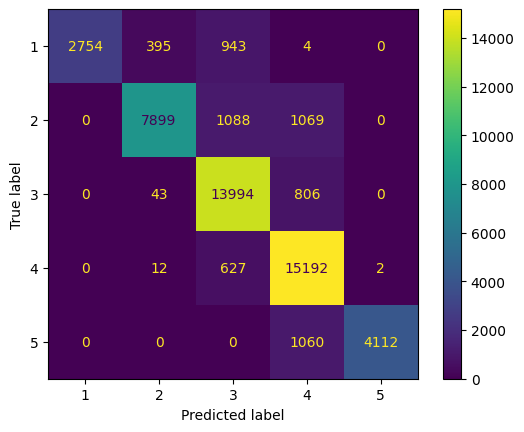

In [31]:
results_train['confusion_matrix_display'].plot()

In [37]:
print(results_test['confusion_matrix_print_table'])

╒════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│        │   Pred:1 │   Pred:2 │   Pred:3 │   Pred:4 │   Pred:5 │
╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ True:1 │     2893 │      426 │      552 │        7 │        0 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:2 │        0 │     8090 │      944 │     1143 │        0 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:3 │        0 │       52 │    14294 │      823 │        0 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:4 │        0 │        3 │      455 │    14982 │        1 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:5 │        0 │        0 │        0 │     1070 │     4265 │
╘════════╧══════════╧══════════╧══════════╧══════════╧══════════╛


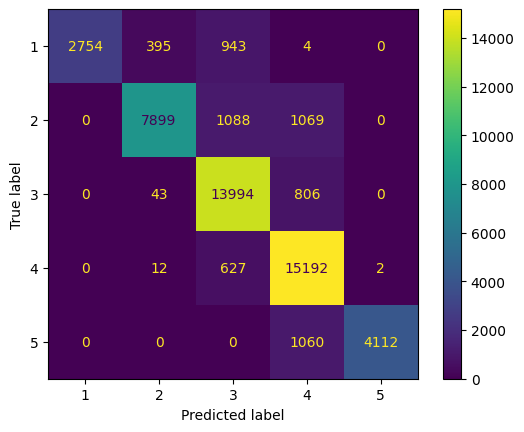

In [25]:
results_train['confusion_matrix_display'].plot()
#plt.savefig('50kTrainConf.png')

### Hyperparameter Choices

In [34]:
t0 = time.time()
#estimator = RandomForestClassifier(n_estimators=50, max_depth=7,random_state=42)

avg_precision_train = 0.0
avg_recall_train = 0.0
avg_f1_train = 0.0
avg_precision_test = 0.0
avg_recall_test = 0.0
avg_f1_test = 0.0
numSplits = 0.0
#
# Now loop

for train_index, test_index in skf.split(X, y):
    #print("Training")
    numSplits += 1
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]  
#
# Now fit to our training set
    results_train,results_test = run_fitter_multi(estimator,X_train,y_train,X_test,y_test,labels)

    avg_precision_train += results_train['report_dict']['weighted avg']['precision']
    avg_recall_train += results_train['report_dict']['weighted avg']['recall']
    avg_f1_train += results_train['report_dict']['weighted avg']['f1-score']
#
    avg_precision_test += results_test['report_dict']['weighted avg']['precision']
    avg_recall_test += results_test['report_dict']['weighted avg']['recall']
    avg_f1_test += results_test['report_dict']['weighted avg']['f1-score']
#
avg_precision_train /= numSplits
avg_recall_train /= numSplits
avg_f1_train /= numSplits
avg_precision_test /= numSplits
avg_recall_test /= numSplits
avg_f1_test /= numSplits
# 
# Now print
print("Precision train/test ",round(avg_precision_train,3),round(avg_precision_test,3))
print("Recall train/test    ",round(avg_recall_train,3),round(avg_recall_test,3))
print("F1 Score train/test       ",round(avg_f1_train,3),round(avg_f1_test,3))
print("All done! Time:", time.time()-t0)
printmem()

Precision train/test  0.924 0.921
Recall train/test     0.917 0.914
F1 Score train/test        0.917 0.914
All done! Time: 1.7886037826538086
   memory: 20.257 Gbytes


In [38]:
# Create a list to store our results
rows = []

for max_depth in range(1,20):
    print("training with max depth =",max_depth)
    #max_features = 8-2
    estimator = RandomForestClassifier(n_estimators=50,random_state=42,max_depth=max_depth)
    avg_precision_train = 0.0
    avg_recall_train = 0.0
    avg_f1_train = 0.0
    avg_precision_test = 0.0
    avg_recall_test = 0.0
    avg_f1_test = 0.0
    numSplits = 0.0
#
# Now loop
    for train_index, test_index in skf.split(X, y):
        numSplits += 1
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

#
# Now fit to our training set
        results_train,results_test = run_fitter_multi(estimator,X_train,y_train,X_test,y_test,labels)

        avg_precision_train += results_train['report_dict']['weighted avg']['precision']
        avg_recall_train += results_train['report_dict']['weighted avg']['recall']
        avg_f1_train += results_train['report_dict']['weighted avg']['f1-score']
#
        avg_precision_test += results_test['report_dict']['weighted avg']['precision']
        avg_recall_test += results_test['report_dict']['weighted avg']['recall']
        avg_f1_test += results_test['report_dict']['weighted avg']['f1-score']
#
    avg_precision_train /= numSplits
    avg_recall_train /= numSplits
    avg_f1_score_train /= numSplits
    
    avg_precision_test /= numSplits
    avg_recall_test /= numSplits
    avg_f1_score_test /= numSplits
#
# Fill dataframe
    rows.append({
        'max_depth':max_depth,
        'trainError_pre':1.0-avg_precision_train,'testError_pre':1.0-avg_precision_test,
        'trainError_rec':1.0-avg_recall_train,'testError_rec':1.0-avg_recall_test,
        'trainError_f1':1.0-avg_f1_score_train,'testError_f1':1.0-avg_f1_score_test
        })
# 
#
# Convert our list of dictionaries to a dataframe
dfError = pd.DataFrame(rows)

# Now print
print(dfError.head())

training with max depth = 1


/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

P

training with max depth = 2


/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/fs/ess/PAS2038/PHYSICS_5680_OSU/jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

P

training with max depth = 3
training with max depth = 4
training with max depth = 5
training with max depth = 6
training with max depth = 7
training with max depth = 8
training with max depth = 9
training with max depth = 10
training with max depth = 11
training with max depth = 12
training with max depth = 13
training with max depth = 14
training with max depth = 15
training with max depth = 16
training with max depth = 17
training with max depth = 18
training with max depth = 19
   max_depth  trainError_pre  testError_pre  trainError_rec  testError_rec  \
0          1        0.640198       0.641796        0.489050         0.4900   
1          2        0.271805       0.292492        0.425325         0.4264   
2          3        0.240480       0.243860        0.311850         0.3153   
3          4        0.193579       0.195710        0.224125         0.2263   
4          5        0.135169       0.135985        0.150750         0.1515   

   trainError_f1  testError_f1  
0           

**Limit max depth to 7 and n estimators to 50**

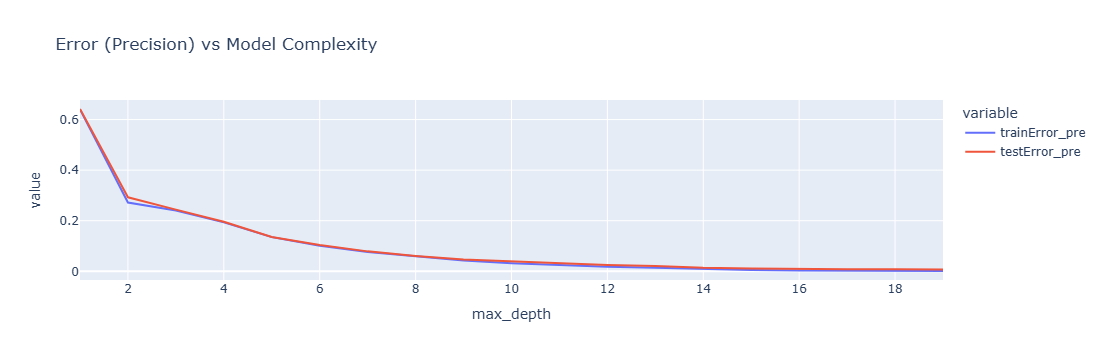

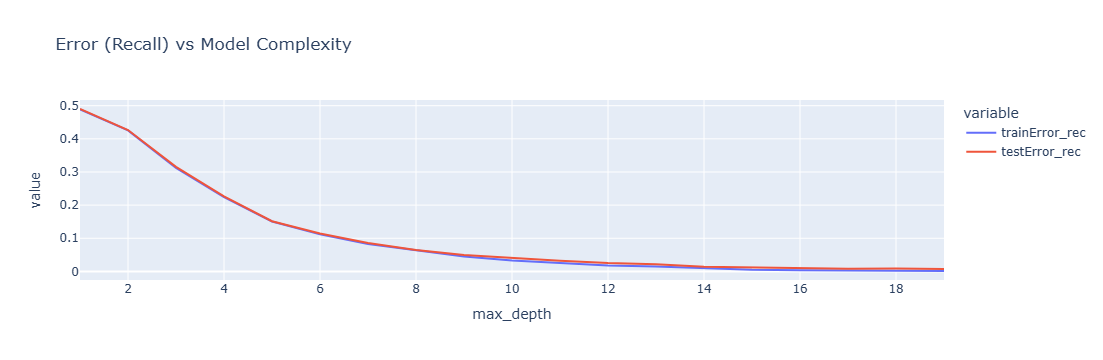

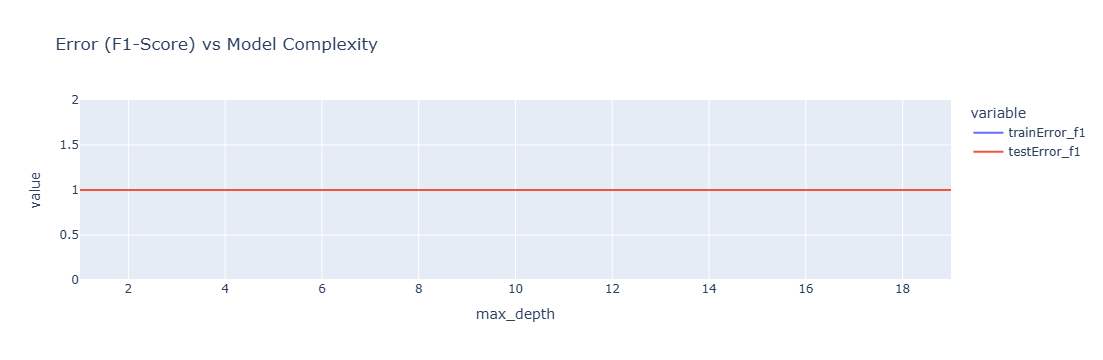

In [39]:
fig = px.line(dfError,x='max_depth', y=['trainError_pre','testError_pre'],
              labels={
                     'y': "Precision Error"
                   },
                      title='Error (Precision) vs Model Complexity')
fig.show()

fig = px.line(dfError,x='max_depth', y=['trainError_rec','testError_rec'],
              labels={
                     'y': "Recall Error"
                   },
                      title='Error (Recall) vs Model Complexity')
fig.show()

fig = px.line(dfError,x='max_depth', y=['trainError_f1','testError_f1'],
              labels={
                     'y': "F1 Error"
                   },
                      title='Error (F1-Score) vs Model Complexity')
fig.show()

## Importing Model from OSC Job

In [11]:
estimator = pickle.load(open('runForestRun2.sav', 'rb'))

In [12]:
y_train_pred = estimator.predict(X_train)
#
# Now predict the classes for our test set
y_test_pred = estimator.predict(X_test)
#
# Get resulst for train
results_train = calc_performance_multi(y_train,y_train_pred,labels)
#
# Get resulst for test
results_test = calc_performance_multi(y_test,y_test_pred,labels)

In [14]:
print(results_train['confusion_matrix_print_table'])
print(results_test['confusion_matrix_print_table'])

╒════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│        │   Pred:1 │   Pred:2 │   Pred:3 │   Pred:4 │   Pred:5 │
╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ True:1 │    51444 │     2291 │     9361 │      457 │        0 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:2 │        0 │   138255 │     9419 │    18910 │        0 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:3 │        0 │      945 │   236418 │     9969 │        0 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:4 │        0 │        0 │     7868 │   246835 │       67 │
├────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:5 │        0 │        1 │       14 │    16090 │    72137 │
╘════════╧══════════╧══════════╧══════════╧══════════╧══════════╛
╒════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│        │   Pred:1 │   Pred:2 │   Pred:3 │   Pred:4 │   Pred:5 │
╞════════╪

In [18]:
print(results_train['report_dict']['weighted avg'])
print(results_test['report_dict']['weighted avg'])

{'precision': 0.9164420297398223, 'recall': 0.9081124364854275, 'f1-score': 0.9077187083952841, 'support': 820481.0}
{'precision': 0.9169483747981728, 'recall': 0.9087465447223834, 'f1-score': 0.9083954080869067, 'support': 205121.0}


In [19]:
printmem()

   memory: 20.324 Gbytes


### Feature Importance

In [21]:
print("Raw printout of feature importances.  NOTE the order is the SAME as the order of our features!!")
print(estimator.feature_importances_)
print()

importanceByName = {}
print("unsorted importance:")
for name,importance in zip(df.columns[0:-2],estimator.feature_importances_):
  importanceByName[name] = importance
  print("Name,importance",name,round(importance,3))
#
# Now sort and print
print()
print("Sorted importance:")
for name in sorted(importanceByName, key=importanceByName.get, reverse=True):
  print("Name,importance",name,round(importanceByName[name],3))

Raw printout of feature importances.  NOTE the order is the SAME as the order of our features!!
[5.37918147e-05 2.06415851e-07 1.47251030e-03 2.89135484e-04
 0.00000000e+00 0.00000000e+00 8.13508259e-05 8.48334712e-04
 2.59270746e-03 2.49888485e-03 4.70861044e-03 1.83343851e-03
 4.19638983e-06 1.49805296e-03 1.18634175e-05 9.60197665e-05
 9.25665810e-04 3.73457522e-03 3.14551013e-04 4.56826659e-03
 0.00000000e+00 0.00000000e+00 3.45494599e-05 1.18083957e-04
 2.41595401e-05 4.70905655e-03 5.54785585e-04 6.47706591e-04
 1.34286348e-03 3.73609098e-03 6.12650693e-04 7.22814494e-04
 4.27001513e-04 1.74117190e-03 3.07788862e-02 1.83822877e-04
 0.00000000e+00 8.86770920e-05 9.66457612e-03 4.76062262e-03
 1.81004861e-03 5.49052950e-03 2.65342064e-05 2.31775386e-03
 0.00000000e+00 3.38977244e-04 7.62494535e-05 0.00000000e+00
 0.00000000e+00 1.24075358e-03 2.19889417e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00